In [1]:
!pip install split-folders matplotlib opencv-python spicy

In [2]:
import numpy as np
import cv2 as cv
import os
import splitfolders
import matplotlib.pyplot as plt

# tensorflow
import tensorflow.keras as keras
import tensorflow as tf

# image processing
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img

# model / neural network
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

## Preprocessing

In [3]:
# split data in a new folder named data-split 70% 20% 10%
splitfolders.ratio("data", output="data-split", seed=1337, ratio=(0.7, 0.2, 0.1), group_prefix=None, move=False)

Copying files: 35984 files [01:43, 347.70 files/s]


In [4]:
datagen = ImageDataGenerator()

In [5]:
# define classes name
class_names = ['A','B','C','H']

In [6]:
# training data
train_generator = datagen.flow_from_directory( 
    directory="data-split/train/", 
    classes = class_names,
    target_size=(224, 224),  
    batch_size=32, 
    class_mode="binary", 
)

Found 25188 images belonging to 4 classes.


In [7]:
# validation data
valid_generator = datagen.flow_from_directory( 
    directory="data-split/val/", 
    classes = class_names,
    target_size=(224, 224), 
    batch_size=32, 
    class_mode="binary", 
)

Found 7196 images belonging to 4 classes.


In [8]:
# test data
test_generator = datagen.flow_from_directory( 
    directory="data-split/test/", 
    classes = class_names,
    target_size=(224, 224), 
    batch_size=32, 
    class_mode="binary", 
)

Found 3600 images belonging to 4 classes.


## Model

In [9]:
# ResNet50 model
resnet_50 = ResNet50(include_top=False, weights='imagenet', input_shape=(224,224,3))
for layer in resnet_50.layers:
    layer.trainable = False

94765736/94765736 [==============================] - 45s 0us/step


In [10]:
# build the entire model
x = resnet_50.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512, activation='relu')(x) 
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation='relu')(x) 
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation='relu')(x) 
x = layers.Dropout(0.5)(x)
x = layers.Dense(64, activation='relu')(x) 
x = layers.Dropout(0.5)(x)
predictions = layers.Dense(4, activation='softmax')(x) # nb de classes
model = Model(inputs = resnet_50.input, outputs = predictions)

## Train 

In [11]:
# define training function
def trainModel(model, epochs, optimizer):
    batch_size = 32
    model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model.fit(train_generator, validation_data=valid_generator, epochs=epochs, batch_size=batch_size)

In [12]:
# launch the training
model_history = trainModel(model = model, epochs = 10, optimizer = "Adam")

Epoch 1/10
788/788 [==============================] - 1904s 2s/step - loss: 0.1920 - accuracy: 0.9302 - val_loss: 0.0011 - val_accuracy: 0.9997
Epoch 2/10
788/788 [==============================] - 2044s 3s/step - loss: 0.0285 - accuracy: 0.9929 - val_loss: 2.0659e-04 - val_accuracy: 1.0000
Epoch 3/10
788/788 [==============================] - 2004s 3s/step - loss: 0.0086 - accuracy: 0.9974 - val_loss: 2.2301e-06 - val_accuracy: 1.0000
Epoch 4/10
788/788 [==============================] - 2235s 3s/step - loss: 0.0239 - accuracy: 0.9954 - val_loss: 1.0265e-05 - val_accuracy: 1.0000
Epoch 5/10
788/788 [==============================] - 2022s 3s/step - loss: 0.0168 - accuracy: 0.9962 - val_loss: 1.3676e-05 - val_accuracy: 1.0000
Epoch 6/10
788/788 [==============================] - 1812s 2s/step - loss: 0.0067 - accuracy: 0.9983 - val_loss: 1.5567e-04 - val_accuracy: 0.9999
Epoch 7/10
788/788 [==============================] - 1787s 2s/step - loss: 0.0049 - accuracy: 0.9987 - val_loss: 0.

### Loss curves 

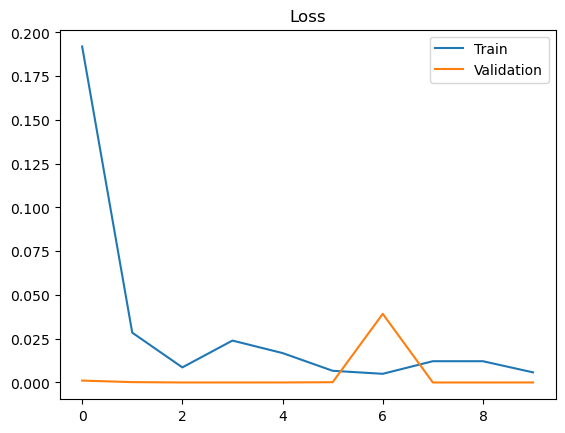

In [13]:
loss_train_curve = model_history.history["loss"]
loss_val_curve = model_history.history["val_loss"]
plt.plot(loss_train_curve, label = "Train")
plt.plot(loss_val_curve, label = "Validation")
plt.legend(loc = 'upper right')
plt.title("Loss")
plt.show()

### Accuracy curves 

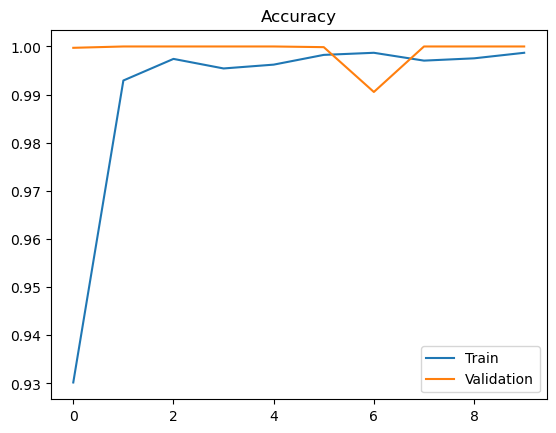

In [14]:
acc_train_curve = model_history.history["accuracy"]
acc_val_curve = model_history.history["val_accuracy"]
plt.plot(acc_train_curve, label = "Train")
plt.plot(acc_val_curve, label = "Validation")
plt.legend(loc = 'lower right')
plt.title("Accuracy")
plt.show()

## Evaluate 

In [15]:
test_loss, test_acc = model.evaluate(test_generator)
print("Test loss: ", test_loss)
print("Best accuracy: ", test_acc*100)

113/113 [==============================] - 209s 2s/step - loss: 4.7515e-06 - accuracy: 1.0000
Test loss:  4.7515272854070645e-06
Best accuracy:  100.0


## Test the model with new image 

In [1]:
img = tf.keras.preprocessing.image.load_img('B6.jpg', target_size=(224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.array([img_array]) 
img

NameError: name 'tf' is not defined

In [18]:
# generate predictions for samples
predictions = model.predict(img_array)
print(predictions)

1/1 [==============================] - 1s 1s/step
[[2.0916454e-08 4.5405271e-10 5.6311227e-09 1.0000000e+00]]


In [19]:
# generate argmax for predictions
class_id = np.argmax(predictions, axis = 1)
print(class_id)

[3]


In [20]:
# transform classes number into classes name
class_names[class_id.item()]

'H'

## Save Model 

In [25]:
model.save('test_mode.h5')

C:\Users\lor3n\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [22]:
# my_model directory
%ls saved_model/

Option non valide - "".


In [23]:
# contains an assets folder, saved_model.pb, and variables folder
%ls saved_model/my_model

Option non valide - "my_model".


In [24]:
model = tf.keras.models.load_model('saved_model/my_model')
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

                                                                                                  
 conv2_block3_1_conv (Conv2  (None, 56, 56, 64)           16448     ['conv2_block2_out[0][0]']    
 D)                                                                                               
                                                                                                  
 conv2_block3_1_bn (BatchNo  (None, 56, 56, 64)           256       ['conv2_block3_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv2_block3_1_relu (Activ  (None, 56, 56, 64)           0         ['conv2_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv2_blo

 ation)                                                                                           
                                                                                                  
 conv3_block2_3_conv (Conv2  (None, 28, 28, 512)          66048     ['conv3_block2_2_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv3_block2_3_bn (BatchNo  (None, 28, 28, 512)          2048      ['conv3_block2_3_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv3_block2_add (Add)      (None, 28, 28, 512)          0         ['conv3_block1_out[0][0]',    
                                                                     'conv3_block2_3_bn[0][0]']   
          

 conv4_block1_2_conv (Conv2  (None, 14, 14, 256)          590080    ['conv4_block1_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv4_block1_2_bn (BatchNo  (None, 14, 14, 256)          1024      ['conv4_block1_2_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block1_2_relu (Activ  (None, 14, 14, 256)          0         ['conv4_block1_2_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_block1_0_conv (Conv2  (None, 14, 14, 1024)         525312    ['conv3_block4_out[0][0]']    
 D)       

                                                                                                  
 conv4_block3_out (Activati  (None, 14, 14, 1024)         0         ['conv4_block3_add[0][0]']    
 on)                                                                                              
                                                                                                  
 conv4_block4_1_conv (Conv2  (None, 14, 14, 256)          262400    ['conv4_block3_out[0][0]']    
 D)                                                                                               
                                                                                                  
 conv4_block4_1_bn (BatchNo  (None, 14, 14, 256)          1024      ['conv4_block4_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_blo

 D)                                                                                               
                                                                                                  
 conv4_block6_3_bn (BatchNo  (None, 14, 14, 1024)         4096      ['conv4_block6_3_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block6_add (Add)      (None, 14, 14, 1024)         0         ['conv4_block5_out[0][0]',    
                                                                     'conv4_block6_3_bn[0][0]']   
                                                                                                  
 conv4_block6_out (Activati  (None, 14, 14, 1024)         0         ['conv4_block6_add[0][0]']    
 on)                                                                                              
          

 conv5_block3_1_relu (Activ  (None, 7, 7, 512)            0         ['conv5_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv5_block3_2_conv (Conv2  (None, 7, 7, 512)            2359808   ['conv5_block3_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv5_block3_2_bn (BatchNo  (None, 7, 7, 512)            2048      ['conv5_block3_2_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv5_block3_2_relu (Activ  (None, 7, 7, 512)            0         ['conv5_block3_2_bn[0][0]']   
 ation)   